# Starbucks Capstone Challenge

# Part 1 - DEFINE

### ---- 1 Define the problem ----

# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [3]:
#import your libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 999

#your info here
__author__ = "Sha Brown"
__email__ = "sha821@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
# load the data into a Pandas dataframe
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [3]:
# display the first 10 rows of the dataframe
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
id_length = lambda x: len(x)
length = portfolio['id'].apply(id_length)
length

0    32
1    32
2    32
3    32
4    32
5    32
6    32
7    32
8    32
9    32
Name: id, dtype: int64

In [5]:
# print dataframe shape
portfolio.shape

(10, 6)

In [6]:
# display the first 5 rows of the dataframe
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
# print dataframe shape
profile.shape

(17000, 5)

In [8]:
# display the first 5 rows of the dataframe
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [9]:
# print dataframe shape
transcript.shape

(306534, 4)

In [10]:
transcript['value'] = (transcript['value']
                       .astype('str')
                       .str.replace('{','')
                       .str.replace('}','')
                      )

In [11]:
transcript['value'] = transcript['value'].str.split(':')

In [12]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,"['offer id', '9b98b8c7a33c4b65b9aebfe6a799e6d9']",0
1,a03223e636434f42ac4c3df47e8bac43,offer received,"['offer id', '0b1e1539f2cc45b7b9fa7c272da2e1d7']",0
2,e2127556f4f64592b11af22de27a7932,offer received,"['offer id', '2906b810c7d4411798c6938adc9daaa5']",0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,"['offer id', 'fafdcd668e3743c1bb461111dcafc2a4']",0
4,68617ca6246f4fbc85e91a2a49552598,offer received,"['offer id', '4d5c57ea9a6940dd891ad53e9dbe8da0']",0


In [13]:
transcript.loc[0, 'value'][0]

"'offer id'"

In [14]:
transcript.loc[0, 'value'][1]

" '9b98b8c7a33c4b65b9aebfe6a799e6d9'"

In [15]:
extract_offer = lambda x: x[0]
extract_value = lambda x: x[1]

transcript['offer_or_amount'] = transcript['value'].apply(extract_offer)
transcript['id'] = transcript['value'].apply(extract_value)

In [16]:
transcript = transcript.drop('value', axis=1)

In [17]:
transcript.head()

,person,event,time,offer_or_amount,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,'offer id','9b98b8c7a33c4b65b9aebfe6a799e6d9'
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,'offer id','0b1e1539f2cc45b7b9fa7c272da2e1d7'
2,e2127556f4f64592b11af22de27a7932,offer received,0,'offer id','2906b810c7d4411798c6938adc9daaa5'
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,'offer id','fafdcd668e3743c1bb461111dcafc2a4'
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,'offer id','4d5c57ea9a6940dd891ad53e9dbe8da0'


In [18]:
transcript['offer_or_amount'] = (transcript['offer_or_amount']
                       .str.replace('_', '')
                       .str.replace("'", "")
                       )

In [19]:
transcript['id'] = transcript['id'].str.replace("'", "")
                             

In [20]:
# change column name from 'person' to 'customer_id'
transcript.rename(columns={'person': 'customer_id', 'offer':'offer_id'}, inplace=True)

#### Merge Data

In [21]:
# change column name from 'id' to 'customer_id'
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [22]:
# first we will merge transcript with profile 
merged_df = transcript.merge(profile, on='customer_id', how='left')

In [23]:
merged_df.head()

,customer_id,event,time,offer_or_amount,id,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,None,118,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,20171002,NaN


In [24]:
# check the first few rows of the dataframe
merged_df['id'].value_counts().head(20)

 2298d6c36e964ae4a3e7e9706d1fb8c2            14983
 fafdcd668e3743c1bb461111dcafc2a4            14924
 4d5c57ea9a6940dd891ad53e9dbe8da0            14891
 f19421c1d4aa40978ebb69ca19b0e20d            14835
 ae264e3637204a6fb9bb56bc8210ddfd            14374
 5a8bc65990b245e5a138643cd4eb9837            14305
 9b98b8c7a33c4b65b9aebfe6a799e6d9            11848
 3f207df678b143eea3cee63160fa8bed            11761
 2906b810c7d4411798c6938adc9daaa5            11750
 0b1e1539f2cc45b7b9fa7c272da2e1d7            10331
 fafdcd668e3743c1bb461111dcafc2a4, reward     5317
 2298d6c36e964ae4a3e7e9706d1fb8c2, reward     5156
 9b98b8c7a33c4b65b9aebfe6a799e6d9, reward     4354
 f19421c1d4aa40978ebb69ca19b0e20d, reward     4296
 2906b810c7d4411798c6938adc9daaa5, reward     4017
 ae264e3637204a6fb9bb56bc8210ddfd, reward     3688
 0b1e1539f2cc45b7b9fa7c272da2e1d7, reward     3420
 4d5c57ea9a6940dd891ad53e9dbe8da0, reward     3331
 0.05                                          431
 0.66                          

In [25]:
# remove"," and "reward" from offer_value column
merged_df['id'] = merged_df['id'].str.replace(",", "").str.replace('reward', '').str.replace(" ",'')

In [26]:
merged_df['id'].value_counts().head(10)

fafdcd668e3743c1bb461111dcafc2a4    20241
2298d6c36e964ae4a3e7e9706d1fb8c2    20139
f19421c1d4aa40978ebb69ca19b0e20d    19131
4d5c57ea9a6940dd891ad53e9dbe8da0    18222
ae264e3637204a6fb9bb56bc8210ddfd    18062
9b98b8c7a33c4b65b9aebfe6a799e6d9    16202
2906b810c7d4411798c6938adc9daaa5    15767
5a8bc65990b245e5a138643cd4eb9837    14305
0b1e1539f2cc45b7b9fa7c272da2e1d7    13751
3f207df678b143eea3cee63160fa8bed    11761
Name: id, dtype: int64

In [27]:
# print out the shape of the dataframe
merged_df.shape

(306534, 9)

In [28]:
merged_df['offer_or_amount'].value_counts()

amount      138953
offer id    134002
offerid      33579
Name: offer_or_amount, dtype: int64

In [29]:
merged_df['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [30]:
merged_df = merged_df.merge(portfolio, on='id', how='left')

In [31]:
merged_df.head()

,customer_id,event,time,offer_or_amount,id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,None,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


In [ ]:
merged_df.isnull().sum()

### ---- 3 Clean the data ----

In [32]:
# extract all available channels
channels_set = set()
for channel in portfolio.channels:
    channels_set.update(set(channel))
channels_set

{'email', 'mobile', 'social', 'web'}

In [33]:
# create new columns corresponding to channels
for i in channels_set:
    merged_df[i] = merged_df['channels'].astype('str').apply(lambda x: i in x).map({True:1, False: 0})
merged_df.head()

,customer_id,event,time,offer_or_amount,id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,mobile,social,web,email
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,0,1,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,discount,0,0,1,1
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0,2.0,"[web, email, mobile]",10.0,7.0,discount,1,0,1,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,None,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1,1,1,1
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,1,1,1,1


In [34]:
# Create a one hot encoding function
def one_hot_encoding(dataframe, column_list):
    for column in column_list:
        column_dummies = pd.get_dummies(dataframe[column])
        dataframe = dataframe.drop(column, axis = 1)
        dataframe = dataframe.join(column_dummies)
    return dataframe

In [35]:
# Create dummy variables for columns in the column list
column_list = ['event', 'gender', 'offer_type']
merged_df = one_hot_encoding(merged_df, column_list)

In [36]:
merged_df.head()

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,mobile,social,web,email,offer completed,offer received,offer viewed,transaction,F,M,O,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,1,0,1,1,0,1,0,0,1,0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,0,0,1,1,0,1,0,0,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,offer id,2906b810c7d4411798c6938adc9daaa5,68,20180426,70000.0,2.0,"[web, email, mobile]",10.0,7.0,1,0,1,1,0,1,0,0,0,1,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,1,1,1,1,0,1,0,0,0,0,0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,1,1,1,1,0,1,0,0,0,0,0,1,0,0


In [37]:
merged_df.sort_values('customer_id').head(20)

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,mobile,social,web,email,offer completed,offer received,offer viewed,transaction,F,M,O,bogo,discount,informational
302205,0009655768c64bdeb2e877511632db8f,696,amount,18.41,33,20170421,72000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,0
168412,0009655768c64bdeb2e877511632db8f,414,amount,8.57,33,20170421,72000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,0
300930,0009655768c64bdeb2e877511632db8f,690,amount,28.16,33,20170421,72000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,0
55972,0009655768c64bdeb2e877511632db8f,168,offer id,5a8bc65990b245e5a138643cd4eb9837,33,20170421,72000.0,0.0,"[email, mobile, social]",0.0,3.0,1,1,0,1,0,1,0,0,0,1,0,0,0,1
153401,0009655768c64bdeb2e877511632db8f,408,offer id,f19421c1d4aa40978ebb69ca19b0e20d,33,20170421,72000.0,5.0,"[web, email, mobile, social]",5.0,5.0,1,1,1,1,0,1,0,0,0,1,0,1,0,0
233413,0009655768c64bdeb2e877511632db8f,540,offer id,fafdcd668e3743c1bb461111dcafc2a4,33,20170421,72000.0,2.0,"[web, email, mobile, social]",10.0,10.0,1,1,1,1,0,0,1,0,0,1,0,0,1,0
228422,0009655768c64bdeb2e877511632db8f,528,amount,14.11,33,20170421,72000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,0
228423,0009655768c64bdeb2e877511632db8f,528,offerid,fafdcd668e3743c1bb461111dcafc2a4,33,20170421,72000.0,2.0,"[web, email, mobile, social]",10.0,10.0,1,1,1,1,1,0,0,0,0,1,0,0,1,0
77705,0009655768c64bdeb2e877511632db8f,192,offer id,5a8bc65990b245e5a138643cd4eb9837,33,20170421,72000.0,0.0,"[email, mobile, social]",0.0,3.0,1,1,0,1,0,0,1,0,0,1,0,0,0,1
293497,0009655768c64bdeb2e877511632db8f,660,amount,12.36,33,20170421,72000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [38]:
merged_df['customer_id'].nunique()

17000

In [39]:
merged_df['customer_id'].unique()

array(['78afa995795e4d85b5d9ceeca43f5fef',
       'a03223e636434f42ac4c3df47e8bac43',
       'e2127556f4f64592b11af22de27a7932', ...,
       '912b9f623b9e4b4eb99b6dc919f09a93',
       '3045af4e98794a04a5542d3eac939b1f',
       'da7a7c0dcfcb41a8acc7864a53cf60fb'], dtype=object)

In [40]:
portfolio['id'].unique()

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [41]:
merged_df['offer_or_amount'] = merged_df['offer_or_amount'].str.replace('offerid', 'offer id')

In [42]:
merged_df['offer_or_amount'].value_counts()

offer id    167581
amount      138953
Name: offer_or_amount, dtype: int64

In [43]:
merged_df.shape

(306534, 25)

In [44]:
def sort_by_event(df, event_col, time_name):
    new_df = df[df[event_col]==1].copy()
    new_df[time_name] = new_df['time']
    new_df.sort_values('time', ascending=True, inplace=True)
    new_df.drop_duplicates(subset=['customer_id', 'id'], keep='first', inplace=True)
    return new_df

In [45]:
received_df = sort_by_event(merged_df, 'offer received', 'received time')

In [46]:
received_df = received_df.drop(columns=['offer completed', 'offer viewed'], axis=1)

In [47]:
viewed_df = sort_by_event(merged_df, 'offer viewed', 'viewed time')

In [48]:
viewed_df = viewed_df[['customer_id','id','offer viewed', 'viewed time']]

In [49]:
viewed_df.head()

,customer_id,id,offer viewed,viewed time
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0
14605,bf5783772fee4f2ab126f07bf3be80f1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0
14604,14cbeafc2297453e9bf4924c2eabe35e,fafdcd668e3743c1bb461111dcafc2a4,1,0
14603,324cde983eef4759ace1e2e30816b751,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0
14602,79e3b16de4964b6c82e45e0014a42502,5a8bc65990b245e5a138643cd4eb9837,1,0


In [50]:
completed_df = sort_by_event(merged_df, 'offer completed', 'completed time')

In [51]:
completed_df = completed_df[['customer_id', 'id','offer completed', 'completed time']]

In [52]:
print(received_df.shape)

(63288, 24)


In [53]:
print(viewed_df.shape)

(49135, 4)


In [54]:
print(completed_df.shape)

(28996, 4)


In [55]:
merged_events = pd.merge(received_df,viewed_df, on=['customer_id', 'id'], how='left')

In [56]:
merged_events.head()

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,mobile,social,web,email,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,1,0,1,1,1,0,1,0,0,1,0,0,0,1.0,6.0
1,05c001b0be8a436dba8f7fdb7ac9273b,0,offer id,5a8bc65990b245e5a138643cd4eb9837,78,20170708,42000.0,0.0,"[email, mobile, social]",0.0,3.0,1,1,0,1,1,0,1,0,0,0,0,1,0,1.0,90.0
2,64257c0ea273425d8821644f040b79d9,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,24,20170825,64000.0,2.0,"[web, email, mobile, social]",10.0,10.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,0.0
3,353697e3573c49cebed67da5d6fb49f9,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,20180210,NaN,5.0,"[web, email]",20.0,10.0,0,0,1,1,1,0,0,0,0,0,1,0,0,1.0,84.0
4,aff95fbae22348daa57ca6ef60a85f8c,0,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,59,20180226,41000.0,3.0,"[web, email, mobile, social]",7.0,7.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,6.0


In [57]:
merged_events = pd.merge(merged_events, completed_df, on=['customer_id', 'id'], how='left')

In [58]:
merged_events.shape

(63288, 28)

In [59]:
merged_events.head()

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,mobile,social,web,email,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,1,0,1,1,1,0,1,0,0,1,0,0,0,1.0,6.0,1.0,132.0
1,05c001b0be8a436dba8f7fdb7ac9273b,0,offer id,5a8bc65990b245e5a138643cd4eb9837,78,20170708,42000.0,0.0,"[email, mobile, social]",0.0,3.0,1,1,0,1,1,0,1,0,0,0,0,1,0,1.0,90.0,NaN,NaN
2,64257c0ea273425d8821644f040b79d9,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,24,20170825,64000.0,2.0,"[web, email, mobile, social]",10.0,10.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,0.0,1.0,156.0
3,353697e3573c49cebed67da5d6fb49f9,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,20180210,NaN,5.0,"[web, email]",20.0,10.0,0,0,1,1,1,0,0,0,0,0,1,0,0,1.0,84.0,NaN,NaN
4,aff95fbae22348daa57ca6ef60a85f8c,0,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,59,20180226,41000.0,3.0,"[web, email, mobile, social]",7.0,7.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,6.0,1.0,78.0


In [60]:
merged_events[merged_events['offer completed']==1.0].head(20)

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,mobile,social,web,email,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,1,0,1,1,1,0,1,0,0,1,0,0,0,1.0,6.0,1.0,132.0
2,64257c0ea273425d8821644f040b79d9,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,24,20170825,64000.0,2.0,"[web, email, mobile, social]",10.0,10.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,0.0,1.0,156.0
4,aff95fbae22348daa57ca6ef60a85f8c,0,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,59,20180226,41000.0,3.0,"[web, email, mobile, social]",7.0,7.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,6.0,1.0,78.0
8,546e724e2f474bea9d1c94c0590a45ef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,57,20180719,47000.0,5.0,"[web, email, mobile]",5.0,7.0,1,0,1,1,1,0,0,1,0,1,0,0,0,1.0,204.0,1.0,216.0
9,69da9853477043e6bdfdddc640787db5,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,46,20170915,65000.0,10.0,"[web, email, mobile, social]",10.0,5.0,1,1,1,1,1,0,0,1,0,1,0,0,0,1.0,0.0,1.0,12.0
10,25a6c63aec2747b39c62a7a0565ed7b0,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,37,20160109,37000.0,5.0,"[web, email, mobile]",5.0,7.0,1,0,1,1,1,0,1,0,0,1,0,0,0,NaN,NaN,1.0,30.0
12,44cd266479b04e20abf7b4abeeaba92e,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,46,20160520,34000.0,5.0,"[web, email, mobile]",5.0,7.0,1,0,1,1,1,0,0,1,0,1,0,0,0,1.0,12.0,1.0,66.0
13,0276c9a3092d4f79a29d61a1462f9b4d,0,offer id,2906b810c7d4411798c6938adc9daaa5,43,20170526,56000.0,2.0,"[web, email, mobile]",10.0,7.0,1,0,1,1,1,0,0,0,1,0,1,0,0,1.0,12.0,1.0,30.0
17,90cfba91804d4402a284481e53f50efc,0,offer id,ae264e3637204a6fb9bb56bc8210ddfd,37,20160415,48000.0,10.0,"[email, mobile, social]",10.0,7.0,1,1,0,1,1,0,1,0,0,1,0,0,0,1.0,0.0,1.0,72.0
18,88ed0c64fb0d474ebca47efa94d623eb,0,offer id,ae264e3637204a6fb9bb56bc8210ddfd,70,20170404,74000.0,10.0,"[email, mobile, social]",10.0,7.0,1,1,0,1,1,0,1,0,0,1,0,0,0,1.0,78.0,1.0,72.0


In [61]:
merged_events[(merged_events['viewed time']) > (merged_events['completed time'])]

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,mobile,social,web,email,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time
18,88ed0c64fb0d474ebca47efa94d623eb,0,offer id,ae264e3637204a6fb9bb56bc8210ddfd,70,20170404,74000.0,10.0,"[email, mobile, social]",10.0,7.0,1,1,0,1,1,0,1,0,0,1,0,0,0,1.0,78.0,1.0,72.0
51,24e1795cb9894e078644210adf514d18,0,offer id,2906b810c7d4411798c6938adc9daaa5,55,20180315,79000.0,2.0,"[web, email, mobile]",10.0,7.0,1,0,1,1,1,0,0,0,1,0,1,0,0,1.0,66.0,1.0,42.0
55,8eecf3a6faf84c2d8ece8898c91c86b3,0,offer id,ae264e3637204a6fb9bb56bc8210ddfd,69,20170915,102000.0,10.0,"[email, mobile, social]",10.0,7.0,1,1,0,1,1,0,0,1,0,1,0,0,0,1.0,696.0,1.0,126.0
72,45e5d63c00cc41bd8d8d6f11e43b4d67,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,78,20151004,79000.0,10.0,"[web, email, mobile, social]",10.0,5.0,1,1,1,1,1,0,1,0,0,1,0,0,0,1.0,18.0,1.0,6.0
86,e95473793bf441cb96dca619d37777ed,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,48,20180308,84000.0,5.0,"[web, email, mobile]",5.0,7.0,1,0,1,1,1,0,1,0,0,1,0,0,0,1.0,114.0,1.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63246,0fc637442b954432b13c360af61d4256,576,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,43,20150803,57000.0,3.0,"[web, email, mobile, social]",7.0,7.0,1,1,1,1,1,0,1,0,0,0,1,0,576,1.0,600.0,1.0,576.0
63272,313fac53644243e49cb3153e34176463,576,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,61,20170905,97000.0,10.0,"[web, email, mobile, social]",10.0,5.0,1,1,1,1,1,0,0,1,0,1,0,0,576,1.0,588.0,1.0,576.0
63279,3bc615dbfcdd40039113a5f9824c892f,576,offer id,f19421c1d4aa40978ebb69ca19b0e20d,36,20170730,46000.0,5.0,"[web, email, mobile, social]",5.0,5.0,1,1,1,1,1,0,0,1,0,1,0,0,576,1.0,678.0,1.0,600.0
63284,94206fc6b89b4ae8b39d2cc9d870ef4d,576,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,61,20161019,114000.0,10.0,"[web, email, mobile, social]",10.0,5.0,1,1,1,1,1,0,0,1,0,1,0,0,576,1.0,612.0,1.0,582.0


In [62]:
merged_events.to_csv('merged_events.csv', index=False)

In [63]:
merged_events = pd.read_csv('merged_events.csv')

In [64]:
merged_events.head()

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,mobile,social,web,email,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,100000.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,1,0,1,1,1,0,1,0,0,1,0,0,0,1.0,6.0,1.0,132.0
1,05c001b0be8a436dba8f7fdb7ac9273b,0,offer id,5a8bc65990b245e5a138643cd4eb9837,78,20170708,42000.0,0.0,"['email', 'mobile', 'social']",0.0,3.0,1,1,0,1,1,0,1,0,0,0,0,1,0,1.0,90.0,NaN,NaN
2,64257c0ea273425d8821644f040b79d9,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,24,20170825,64000.0,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,0.0,1.0,156.0
3,353697e3573c49cebed67da5d6fb49f9,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,20180210,NaN,5.0,"['web', 'email']",20.0,10.0,0,0,1,1,1,0,0,0,0,0,1,0,0,1.0,84.0,NaN,NaN
4,aff95fbae22348daa57ca6ef60a85f8c,0,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,59,20180226,41000.0,3.0,"['web', 'email', 'mobile', 'social']",7.0,7.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,6.0,1.0,78.0


In [65]:
merged_events.isnull().sum()

customer_id             0
time                    0
offer_or_amount         0
id                      0
age                     0
became_member_on        0
income               8066
reward                  0
channels                0
difficulty              0
duration                0
mobile                  0
social                  0
web                     0
email                   0
offer received          0
transaction             0
F                       0
M                       0
O                       0
bogo                    0
discount                0
informational           0
received time           0
offer viewed        14153
viewed time         14153
offer completed     34292
completed time      34292
dtype: int64

In [66]:
merged_events.duplicated().sum()

0

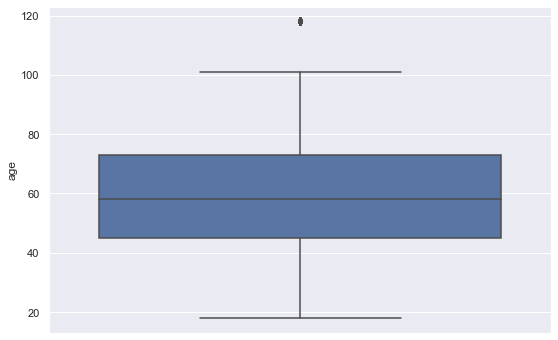

In [67]:
# identify outliers
plt.figure(figsize=(9,6))
sns.set(style='darkgrid')
sns.boxplot(y=merged_events['age'])

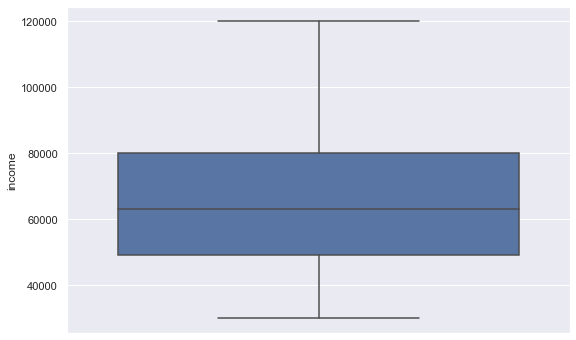

In [68]:
# identify outliers
plt.figure(figsize=(9,6))
sns.boxplot(y=merged_events['income'])

In [69]:
def find_boundaries(df, variable):

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

In [70]:
upper_boundary, lower_boundary = find_boundaries(merged_events, 'age')
upper_boundary, lower_boundary

(115.0, 3.0)

In [71]:
merged_events['age'].value_counts(bins = 10).sort_index(ascending=True)

(17.898999999999997, 28.0]     5442
(28.0, 38.0]                   5520
(38.0, 48.0]                   8023
(48.0, 58.0]                  13063
(58.0, 68.0]                  11573
(68.0, 78.0]                   7072
(78.0, 88.0]                   3330
(88.0, 98.0]                   1122
(98.0, 108.0]                    77
(108.0, 118.0]                 8066
Name: age, dtype: int64

In [72]:
len(merged_events[merged_events['age']>115])

8066

In [73]:
min(merged_events['age'])

18

In [74]:
min(merged_events['income'])

30000.0

In [75]:
merged_events["age"] = np.where(merged_events["age"] >115, np.nan, merged_events['age'])

In [76]:
merged_events['age'].value_counts(bins=12)

(52.583, 59.5]      9503
(59.5, 66.417]      8131
(45.667, 52.583]    7602
(66.417, 73.333]    6285
(38.75, 45.667]     5308
(31.833, 38.75]     4145
(73.333, 80.25]     3772
(24.917, 31.833]    3537
(17.916, 24.917]    3280
(80.25, 87.167]     2225
(87.167, 94.083]    1176
(94.083, 101.0]      258
Name: age, dtype: int64

In [77]:
merged_events['income'].isnull().sum()

8066

In [78]:
merged_events['age'] = merged_events['age'].replace(np.nan, 0)

In [79]:
merged_events['income'] = merged_events['income'].replace(np.nan, 0)

In [80]:
merged_events.fillna(0,inplace=True)

In [81]:
merged_events.isnull().sum()

customer_id         0
time                0
offer_or_amount     0
id                  0
age                 0
became_member_on    0
income              0
reward              0
channels            0
difficulty          0
duration            0
mobile              0
social              0
web                 0
email               0
offer received      0
transaction         0
F                   0
M                   0
O                   0
bogo                0
discount            0
informational       0
received time       0
offer viewed        0
viewed time         0
offer completed     0
completed time      0
dtype: int64

In [82]:
merged_events['became_member_on'] = pd.to_datetime(merged_events['became_member_on'], format='%Y%m%d')

In [83]:
merged_events.head(2)

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,mobile,social,web,email,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,100000.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,1,0,1,1,1,0,1,0,0,1,0,0,0,1.0,6.0,1.0,132.0
1,05c001b0be8a436dba8f7fdb7ac9273b,0,offer id,5a8bc65990b245e5a138643cd4eb9837,78.0,2017-07-08,42000.0,0.0,"['email', 'mobile', 'social']",0.0,3.0,1,1,0,1,1,0,1,0,0,0,0,1,0,1.0,90.0,0.0,0.0


In [84]:
merged_events['became_member_on'].min()

Timestamp('2013-07-29 00:00:00')

In [85]:
ts = pd.to_datetime('20200101', format='%Y%m%d')

In [86]:
merged_events['membership length'] = ts - merged_events['became_member_on']

In [87]:
merged_events['membership length'] = merged_events['membership length'].astype('str').str[0:4].replace(" ",'')

In [88]:
merged_events.head(2)

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,mobile,social,web,email,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time,membership length
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,100000.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,1,0,1,1,1,0,1,0,0,1,0,0,0,1.0,6.0,1.0,132.0,967
1,05c001b0be8a436dba8f7fdb7ac9273b,0,offer id,5a8bc65990b245e5a138643cd4eb9837,78.0,2017-07-08,42000.0,0.0,"['email', 'mobile', 'social']",0.0,3.0,1,1,0,1,1,0,1,0,0,0,0,1,0,1.0,90.0,0.0,0.0,907


In [89]:
merged_events.dtypes

customer_id                  object
time                          int64
offer_or_amount              object
id                           object
age                         float64
became_member_on     datetime64[ns]
income                      float64
reward                      float64
channels                     object
difficulty                  float64
duration                    float64
mobile                        int64
social                        int64
web                           int64
email                         int64
offer received                int64
transaction                   int64
F                             int64
M                             int64
O                             int64
bogo                          int64
discount                      int64
informational                 int64
received time                 int64
offer viewed                float64
viewed time                 float64
offer completed             float64
completed time              

In [90]:
# convert dtypes into integer
merged_events['membership length'] = merged_events['membership length'].astype('int')
merged_events['offer viewed'] = merged_events['offer viewed'].astype('int')
merged_events['offer completed'] = merged_events['offer completed'].astype('int')

In [91]:
merged_events.columns

Index(['customer_id', 'time', 'offer_or_amount', 'id', 'age',
       'became_member_on', 'income', 'reward', 'channels', 'difficulty',
       'duration', 'mobile', 'social', 'web', 'email', 'offer received',
       'transaction', 'F', 'M', 'O', 'bogo', 'discount', 'informational',
       'received time', 'offer viewed', 'viewed time', 'offer completed',
       'completed time', 'membership length'],
      dtype='object')

In [92]:
# drop columns that we no longer needs
merged_events = merged_events.drop(['customer_id', 'time', 
                                    'offer_or_amount', 'id', 
                                    'became_member_on','channels',
                                    'offer received', 'transaction'],
                                    axis = 1
                                   )

In [93]:
merged_events.head()

,age,income,reward,difficulty,duration,mobile,social,web,email,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time,membership length
0,75.0,100000.0,5.0,5.0,7.0,1,0,1,1,1,0,0,1,0,0,0,1,6.0,1,132.0,967
1,78.0,42000.0,0.0,0.0,3.0,1,1,0,1,1,0,0,0,0,1,0,1,90.0,0,0.0,907
2,24.0,64000.0,2.0,10.0,10.0,1,1,1,1,0,1,0,0,1,0,0,1,0.0,1,156.0,859
3,0.0,0.0,5.0,20.0,10.0,0,0,1,1,0,0,0,0,1,0,0,1,84.0,0,0.0,690
4,59.0,41000.0,3.0,7.0,7.0,1,1,1,1,0,1,0,0,1,0,0,1,6.0,1,78.0,674


In [94]:
merged_events.to_csv('cleaned_df.csv', index=False)

### ---- 4 Explore the data (EDA) ----

In [95]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

In [46]:
cleaned_df = pd.read_csv('cleaned_df.csv')

In [47]:
cleaned_df.describe()

,age,income,reward,difficulty,duration,mobile,social,web,email,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time,membership length
count,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.0,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.00000,63288.000000,63288.000000
mean,47.423113,57054.876122,4.206232,7.711572,6.504819,0.899286,0.599529,0.799425,1.0,0.360384,0.500016,0.012151,0.400092,0.400013,0.199896,306.568070,0.776372,257.775787,0.45816,175.617653,1040.721053
std,24.340307,29725.039293,3.402914,5.541480,2.203565,0.300952,0.489998,0.400434,0.0,0.480116,0.500004,0.109560,0.489921,0.489904,0.399925,199.278082,0.416679,225.218185,0.49825,232.390984,411.659882
min,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,524.000000
25%,33.000000,40000.000000,2.000000,5.000000,5.000000,1.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,1.000000,0.000000,0.00000,0.000000,732.000000
50%,52.000000,59000.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,336.000000,1.000000,216.000000,0.00000,0.000000,882.000000
75%,64.000000,76000.000000,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,504.000000,1.000000,450.000000,1.00000,402.000000,1315.000000
max,101.000000,120000.000000,10.000000,20.000000,10.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,576.000000,1.000000,714.000000,1.00000,714.000000,2347.000000


In [56]:
def plot_dist(col):
    plt.figure(figsize=(9,6))
    sns.set(style='darkgrid')
    sns.distplot(col, bins=10)
    plt.show()

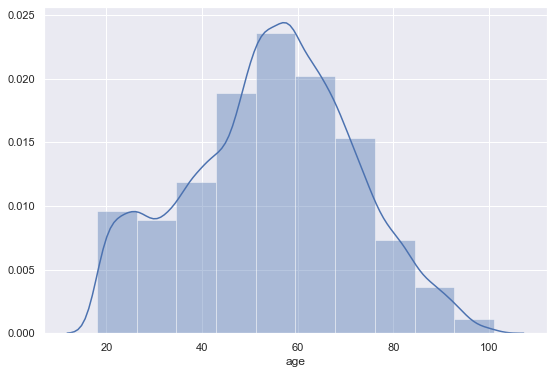

In [57]:
plot_dist(cleaned_df[cleaned_df['age']>0]['age'])

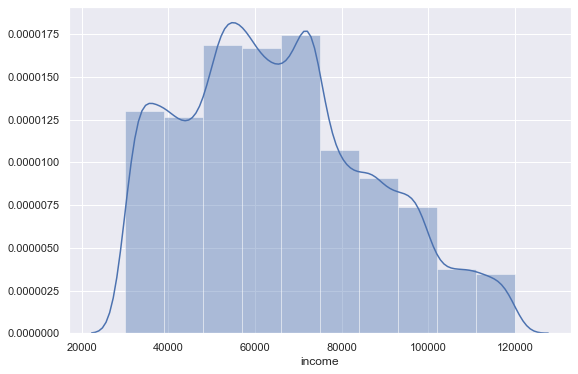

In [60]:
plot_dist(cleaned_df[cleaned_df['income']>0]['income'])

In [61]:
def plot_bar(col):
    plt.figure(figsize=(9,6))
    sns.set(style='darkgrid')
    col.value_counts().plot.bar()
    plt.show()

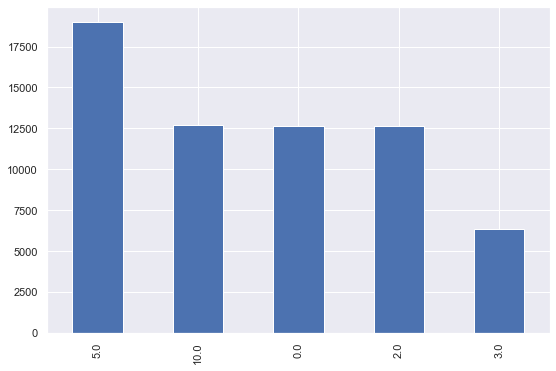

In [62]:
plot_bar(cleaned_df['reward'])

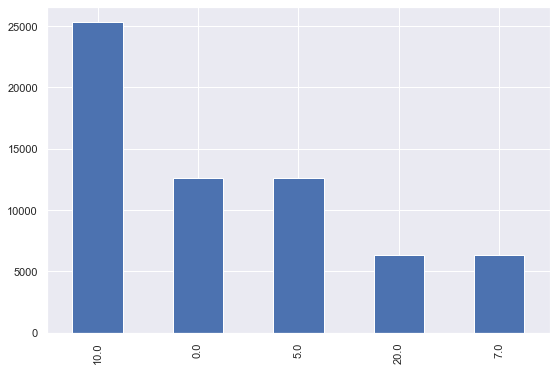

In [63]:
plot_bar(cleaned_df['difficulty'])

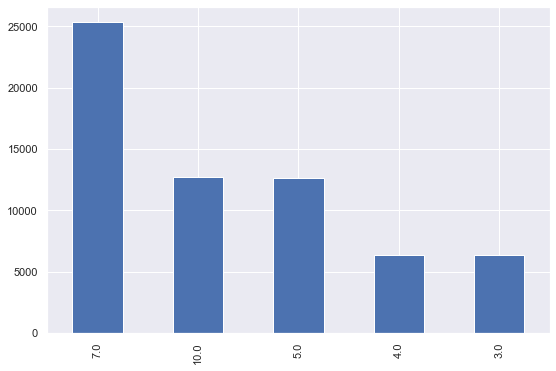

In [64]:
plot_bar(cleaned_df['duration'])

In [128]:
completed_offer_df = cleaned_df[cleaned_df['offer completed']==1].copy()

In [130]:
gender_df = pd.DataFrame({'total': [np.sum(cleaned_df['F']), 
                                    np.sum(cleaned_df['M']), 
                                    np.sum(cleaned_df['O'])],
                          'offer completed': [np.sum(completed_offer_df['F']), 
                                    np.sum(completed_offer_df['M']), 
                                    np.sum(completed_offer_df['O'])]
                          }, 
                          index=['F', 'M', 'O'])

In [135]:
gender_df = gender_df.reset_index().rename(columns={'index':'gender'})

In [ ]:
# Create figure
plt.figure(figsize=(10, 5), dpi=300)
# Create bar plot
pos = np.arange(len(movie_scores['MovieTitle']))
width = 0.3
plt.bar(pos - width / 2, movie_scores['Tomatometer'], width, label='Tomatometer')
plt.bar(pos + width / 2, movie_scores['AudienceScore'], width, label='Audience Score')
# Specify ticks
plt.xticks(pos, rotation=10)
plt.yticks(np.arange(0, 101, 20))
# Get current Axes for setting tick labels and horizontal grid
ax = plt.gca()
# Set tick labels
ax.set_xticklabels(movie_scores['MovieTitle'])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
# Add minor ticks for y-axis in the interval of 5
ax.set_yticks(np.arange(0, 100, 5), minor=True)
# Add major horizontal grid with solid lines
ax.yaxis.grid(which='major')
# Add minor horizontal grid with dashed lines
ax.yaxis.grid(which='minor', linestyle='--')
# Add title
plt.title('Movie comparison')
# Add legend
plt.legend()
# Show plot
plt.show()

In [118]:
def plot_comparison_bar(df):
    plt.figure(figsize=(9,6))
    sns.barplot(data=df, color='#4C72B0')
    plt.show()

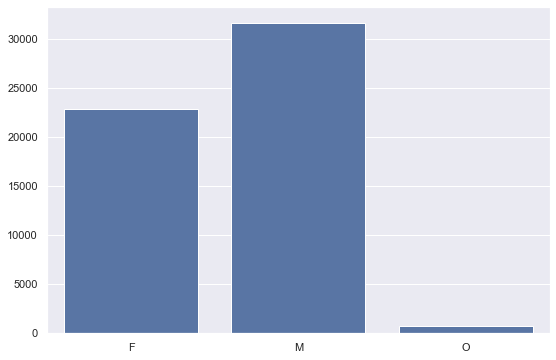

In [119]:
plot_comparison_bar(gender_df)

In [123]:
channel_df = pd.DataFrame({'social': np.sum(cleaned_df['social']), 
                           'web': np.sum(cleaned_df['web']),
                           'mobile': np.sum(cleaned_df['mobile']),
                           'email': np.sum(cleaned_df['email'])}, 
                          index=['total'])

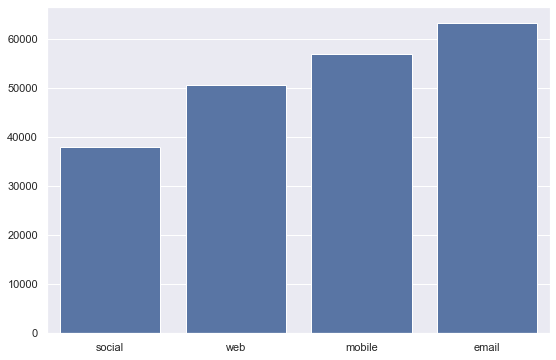

In [124]:
plot_comparison_bar(channel_df)

In [125]:
offer_df = pd.DataFrame({'informational': np.sum(cleaned_df['informational']), 
                         'bogo': np.sum(cleaned_df['web']),
                         'discount': np.sum(cleaned_df['mobile'])}, 
                          index=['total'])

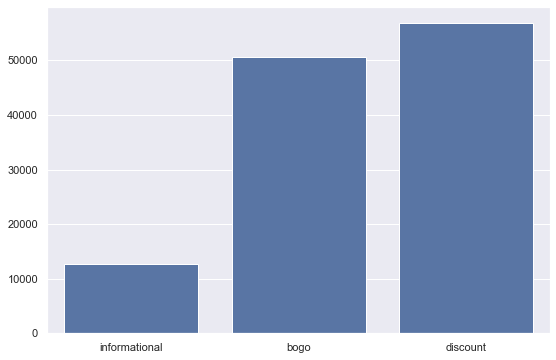

In [126]:
plot_comparison_bar(offer_df)

In [21]:
cleaned_df = cleaned_df.drop('email', axis=1)

In [32]:
cleaned_df[cleaned_df['F']==1]

0        100000.0
1         42000.0
10        37000.0
15        61000.0
16        92000.0
           ...   
63275     42000.0
63276     75000.0
63278     70000.0
63283     84000.0
63285     87000.0
Name: income, Length: 22808, dtype: float64

In [ ]:
# Create figure
plt.figure(dpi=150)
# Set style
sns.set_style('whitegrid')
# Create boxplot
sns.violinplot('Groups', 'IQ score', data=data)
# Despine
sns.despine(left=True, right=True, top=True)
# Add title
plt.title('IQ scores for different test groups')
# Show plot
plt.show()

In [22]:
matrix = cleaned_df.corr()['offer completed']
matrix = matrix.sort_values(ascending=True)

In [23]:
matrix

informational       -0.459622
M                   -0.015505
mobile              -0.006079
received time        0.001378
O                    0.022194
viewed time          0.085397
social               0.088671
bogo                 0.128552
offer viewed         0.148286
membership length    0.159180
F                    0.185562
reward               0.190620
web                  0.208990
age                  0.239139
discount             0.246648
difficulty           0.258943
income               0.301739
duration             0.340080
completed time       0.821826
offer completed      1.000000
Name: offer completed, dtype: float64

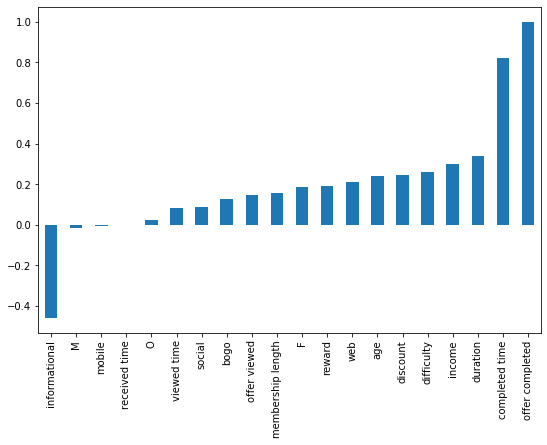

In [24]:
plt.figure(figsize=(9,6))
matrix.plot.bar()

In [25]:
len(cleaned_df[cleaned_df['offer completed']==1])/len(cleaned_df)*100

45.81595247124257

In [27]:
completed_no_promo = cleaned_df[(cleaned_df['offer viewed']==0)&(cleaned_df['offer completed']==1)].copy()                                     

In [28]:
completed_no_promo.shape

(4536, 20)

### ---- 5 Establish a baseline ----

In [ ]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data